In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

import sys
sys.path.append('../../scripts')
import bids_utils
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide

In [2]:
datapath = Path('../../data_axondeepseg_tem/')
derivatives_path = Path('../../scripts/derivatives')
embeddings_path = derivatives_path / 'embeddings'
maps_path = derivatives_path / 'maps'

data_dict = bids_utils.index_bids_dataset(datapath)
data_dict

0 samples collected.


{'sub-nyuMouse07': {'sample-0001': {},
  'sample-0002': {},
  'sample-0003': {},
  'sample-0004': {},
  'sample-0005': {},
  'sample-0006': {},
  'sample-0007': {},
  'sample-0008': {},
  'px_size': 0.00236},
 'sub-nyuMouse09': {'sample-0001': {},
  'sample-0002': {},
  'sample-0003': {},
  'sample-0004': {},
  'sample-0005': {},
  'sample-0006': {},
  'sample-0007': {},
  'sample-0008': {},
  'px_size': 0.00236},
 'sub-nyuMouse10': {'sample-0001': {},
  'sample-0002': {},
  'sample-0003': {},
  'sample-0004': {},
  'sample-0005': {},
  'sample-0006': {},
  'sample-0007': {},
  'sample-0008': {},
  'px_size': 0.00236},
 'sub-nyuMouse11': {'sample-0001': {},
  'sample-0002': {},
  'sample-0003': {},
  'sample-0004': {},
  'sample-0005': {},
  'sample-0006': {},
  'sample-0007': {},
  'sample-0008': {},
  'px_size': 0.00236},
 'sub-nyuMouse12': {'sample-0002': {},
  'sample-0003': {},
  'sample-0004': {},
  'sample-0005': {},
  'sample-0008': {},
  'sample-0009': {},
  'sample-0010': {},

In [3]:
# utility functions to read prompts and labels
%matplotlib inline
def get_sample_bboxes(subject, sample, maps_path):
    prompts_fname = maps_path / subject / 'micr' / f'{subject}_{sample}_prompts.csv'
    prompts_df = pd.read_csv(prompts_fname)
    return prompts_df[['bbox_min_x', 'bbox_min_y', 'bbox_max_x', 'bbox_max_y']]

def get_myelin_bbox(bbox_df, axon_id):
    return np.array(bbox_df.iloc[axon_id])

def get_myelin_map(subject, sample, maps_path):
    map_fname = maps_path / subject / 'micr' / f'{subject}_{sample}_myelinmap.png'
    return cv2.imread(str(map_fname))
    
def get_myelin_mask(myelin_map, axon_id):
    return 255 * (myelin_map == axon_id + 1)

# helper functions to display masks/bboxes
def show_mask(mask, ax):
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

In [4]:
# data loader providing the myelin map (masks), the bboxes (prompts) 
# and the path to the pre-computed image embeddings
def bids_dataloader(data_dict, maps_path, embeddings_path):
    subjects = list(data_dict.keys())
    # we keep the last subject for testing
    for sub in subjects[:-1]:
        samples = (s for s in data_dict[sub].keys() if 'sample' in s)
        for sample in samples:
            emb_path = embeddings_path / sub / 'micr' / f'{sub}_{sample}_TEM_embedding.pt'
            bboxes = get_sample_bboxes(sub, sample, maps_path)
            myelin_map = get_myelin_map(sub, sample, maps_path)
            yield (emb_path, bboxes, myelin_map)

In [5]:
model_type = 'vit_b'
checkpoint = '../../scripts/sam_vit_b_01ec64.pth'
device = 'cuda:3'

sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train();

def load_image_embedding(path):
    emb_dict = torch.load(path, device)
    return emb_dict

In [6]:
lr = 1e-5
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = torch.nn.MSELoss()


  0%|                                                                                                                                                                   | 0/158 [00:30<?, ?it/s]

 25%|██████████████████████████████████████▉                                                                                                                   | 40/158 [03:14<11:22,  5.78s/it]


 51%|██████████████████████████████████████████████████████████████████████████████▉                                                                           | 81/158 [06:58<09:37,  7.50s/it]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 122/158 [11:10<02:24,  4.00s/it]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 150/158 [14:03<01:00,  7.61s/it]

EPOCH 0 MEAN LOSS: 0.013216519407570772


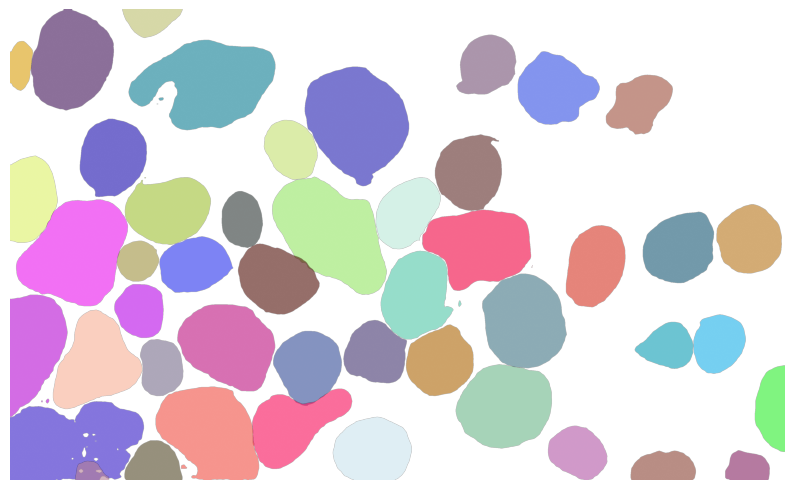

In [15]:
from torch.nn.functional import threshold, normalize

num_epochs = 40
batch_size = 10
losses = []
transform = ResizeLongestSide(sam_model.image_encoder.img_size)

for epoch in range(num_epochs):
    epoch_losses = []
    data_loader = bids_dataloader(data_dict, maps_path, embeddings_path)
    
    pbar = tqdm(total=158)
    for sample in data_loader:
        emb_path, bboxes, myelin_map = sample
        emb_dict = load_image_embedding(emb_path)
        original_size = emb_dict['original_size']
        input_size = emb_dict['input_size']
        image_embedding = emb_dict['features']
        
        if 'sub-nyuMouse28_sample-0006' in str(emb_path):
            # figure to plot all predictions
            plt.figure(figsize=(10, 10))
        
        # train on every axon in the image
        for axon_id in range(len(bboxes)):
            # get mask and bbox prompt
            prompt = get_myelin_bbox(bboxes, axon_id)
            gt_mask = get_myelin_mask(myelin_map, axon_id)
            
            # empty masks should not be processed
            if np.isnan(prompt).any():
                continue
                
            # no grad for the prompt encoder
            with torch.no_grad():
                box = transform.apply_boxes(prompt, original_size)
                box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
                box_torch = box_torch[None, :]
                
                sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                    points=None,
                    boxes=box_torch,
                    masks=None,
                )
            # now we pass the image and prompt embeddings in the mask decoder
            low_res_mask, iou_predictions = sam_model.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=sam_model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )
            
            upscaled_mask = sam_model.postprocess_masks(
                low_res_mask,
                input_size,
                original_size,
            ).to(device)
            binary_mask = normalize(threshold(upscaled_mask, 0.0, 0))
            
            gt_mask_resized = torch.from_numpy(
                np.resize(gt_mask, (1, 1, gt_mask.shape[0], gt_mask.shape[1]))
            ).to(device)
            gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)
            
            loss = loss_fn(binary_mask, gt_binary_mask)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            if 'sub-nyuMouse28_sample-0006' in str(emb_path):
                show_mask(binary_mask.cpu().detach().numpy().squeeze(), plt.gca())
        pbar.update(1)
        # print last 5 losses
#         tqdm.write(str(epoch_losses[-5:]))
        # show prediction halfway in the epoch
        if 'sub-nyuMouse28_sample-0006' in str(emb_path):
            plt.axis('off')
            plt.savefig(f'predictions_epoch_{epoch}')
    losses.append(epoch_losses)
    print(f'EPOCH {epoch} MEAN LOSS: {np.mean(epoch_losses)}')
    if epoch % 5 == 0:
        torch.save(sam_model.state_dict(), f'../../scripts/sam_vit_b_01ec64_epoch_{epoch}.pth')
    
torch.save(sam_model.state_dict(), '../../scripts/sam_vit_b_01ec64_finetuned.pth')

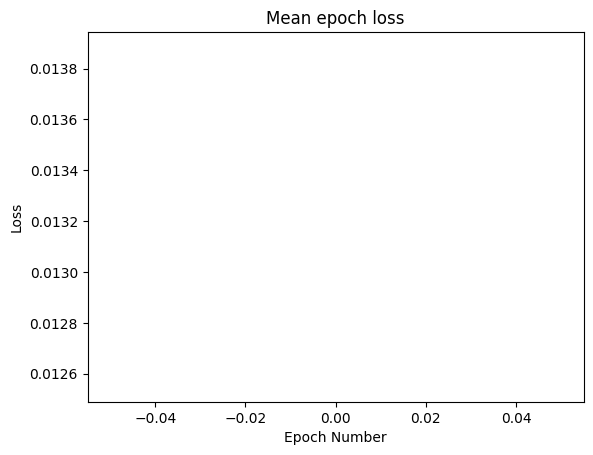

In [16]:
mean_losses = [np.mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.savefig('losses.png')